# Imports

In [10]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


# Setup

### Set size of the figures

In [11]:
plt.rcParams["figure.figsize"] = (6,3.5)
plt.rcParams['figure.dpi'] = 600

### Set desired minimum bucket size for user histogram

In [12]:
min_bucket_size = 30

### Set seed

In [13]:
np.random.seed(0)

### Define helper functions

In [15]:
def check_bucket_size(row):
    """
    Checks if the bucket size is smaller than the minimum bucket size and returns different colors for bars in histogram depending on result.

    :param: row: row of dataframe with bucket size (i.e. count)
    :return: color for bar in histogram
    :rtype: str
    """
    if row["count"] < min_bucket_size:
        return "indianred"
    return "steelblue"

def custom_rounding(val, base):
    """
    Rounds values to the nearest base.

    :param: val: value
    :param: base: base to round to
    :return: rounded value
    :rtype: float
    """
    max_frac_digits = 100
    for i in range(max_frac_digits):
        if round(base, -int(math.floor(math.log10(base))) + i) == base:
            frac_digits = -int(math.floor(math.log10(base))) + i
            break
    return round(round(val / base) * base, frac_digits)

# Simulations

### Create data frame with resting heart rate aggregates

In [16]:
resting_heart_rate_aggregates = np.random.normal(loc=70, scale=8, size=10000)
df_raw = pd.DataFrame(data=resting_heart_rate_aggregates, columns=["value"])

### Process data frame with no rounding

In [21]:
df_no_rounding = df_raw.copy()
df_no_rounding["count"] = df_no_rounding.groupby("value")["value"].transform("count")
df_no_rounding["color"] = df_no_rounding.apply(check_bucket_size, axis=1)
df_no_rounding = df_no_rounding.sort_values(by=["value"])

df_no_rounding

,value,count,color
9770,38.620798,1,indianred
8200,39.306756,1,indianred
7611,40.493078,1,indianred
7677,41.191319,1,indianred
8180,44.067889,1,indianred
...,...,...,...
3716,95.944744,1,indianred
8248,97.019063,1,indianred
6891,98.232442,1,indianred
209,100.821852,1,indianred


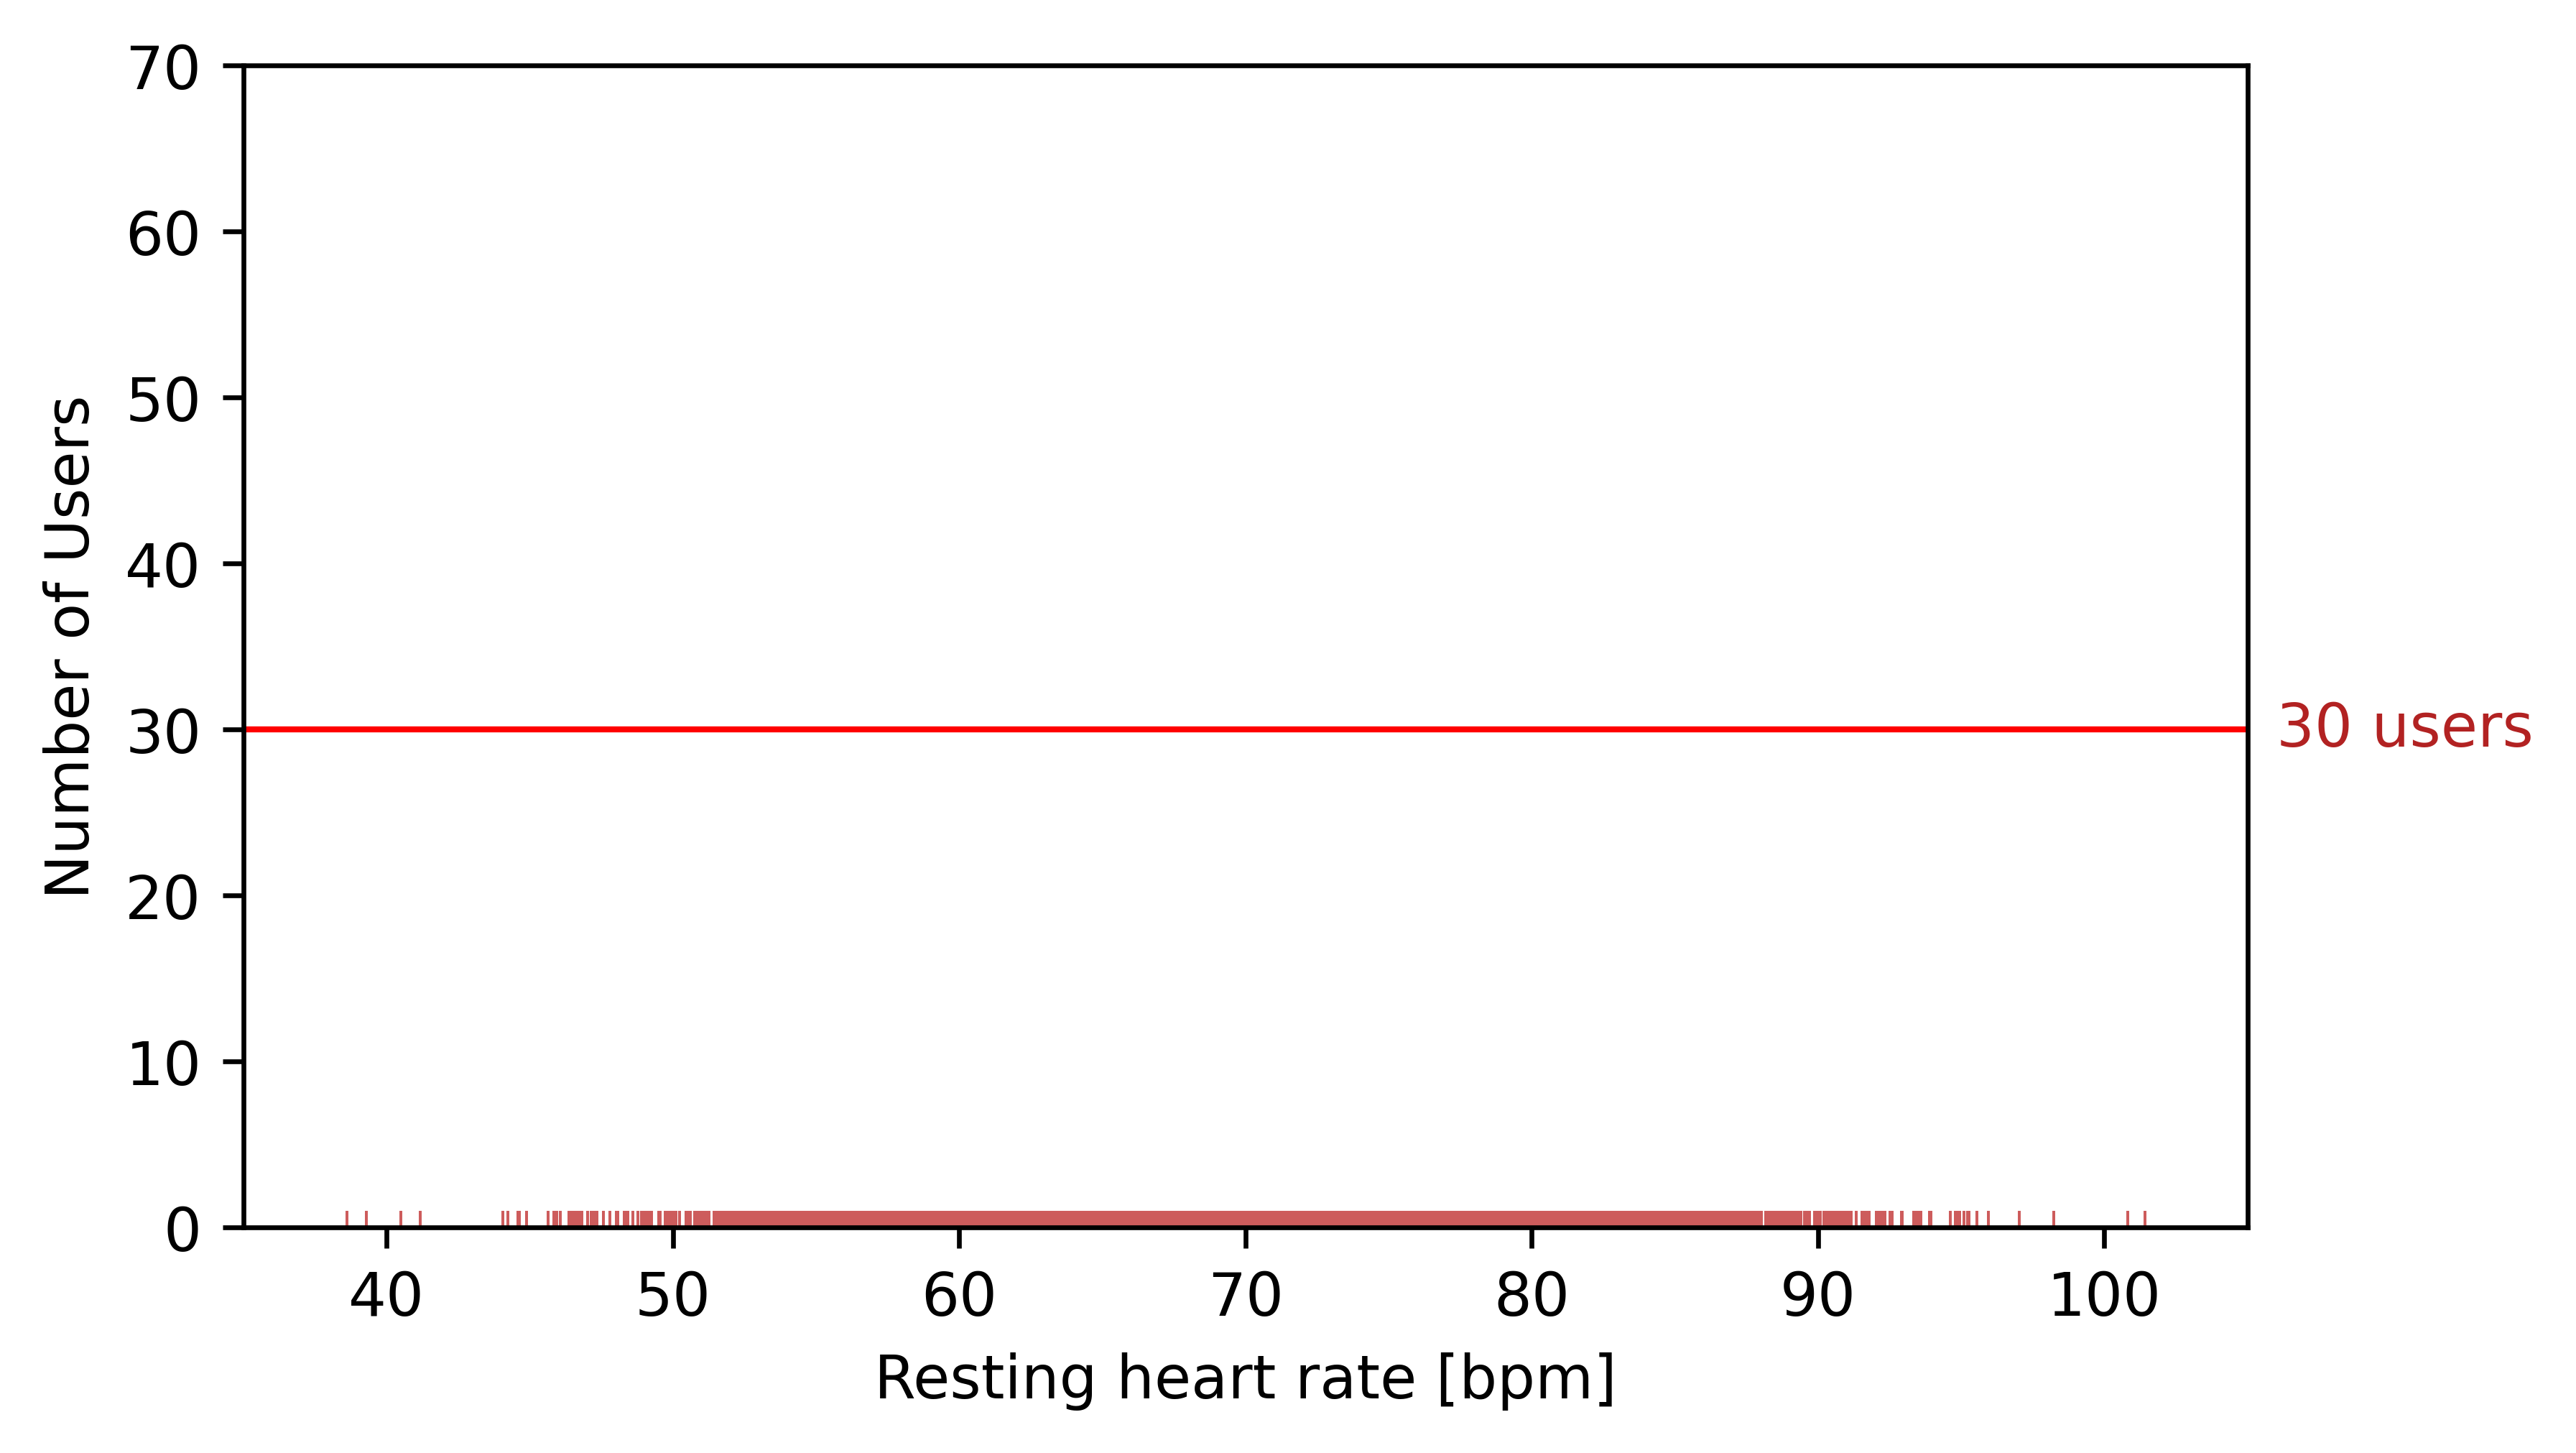

In [22]:
# Plot results without rounding
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=df_raw["value"], height=df_no_rounding["count"], color=df_no_rounding["color"], width=0.1)
ax.set_xlim(left=35, right=105)
ax.set_ylim(bottom=0, top=70)
ax.set_xlabel("Resting heart rate [bpm]")
ax.set_ylabel("Number of Users")

# Plot min bucket size threshold
ax.text(x=106, y=29, s=f"{min_bucket_size} users", color="firebrick")
plt.plot([35, 105], [min_bucket_size, min_bucket_size], linewidth=1, color="red")


plt.savefig("histogram_raw", bbox_inches="tight")
plt.show()

### Process data frame with rounding factor: 0.25

In [20]:
rounding_factor = 0.25
df_rounded_025 = df_raw.copy()
df_rounded_025["value"] = df_rounded_025.apply(custom_rounding, args=(rounding_factor,), axis=1)
df_rounded_025["count"] = df_rounded_025.groupby("value")["value"].transform("count")
df_rounded_025["color"] = df_rounded_025.apply(check_bucket_size, axis=1)
df_rounded_025 = df_rounded_025.sort_values(by="value")

df_rounded_025

,value,count,color
9770,38.50,1,indianred
8200,39.25,1,indianred
7611,40.50,1,indianred
7677,41.25,1,indianred
262,44.00,2,indianred
...,...,...,...
3716,96.00,1,indianred
8248,97.00,1,indianred
6891,98.25,1,indianred
209,100.75,1,indianred


In [30]:
# Calculate cappings and users that need to be added to cap limits
red_buckets_025 = df_rounded_025[df_rounded_025["count"]<min_bucket_size]
left_red_buckets_025 = red_buckets_025[red_buckets_025["value"]<((red_buckets_025["value"].max()+red_buckets_025["value"].min())/2)]
right_red_buckets_025 = red_buckets_025[red_buckets_025["value"]>=((red_buckets_025["value"].max()+red_buckets_025["value"].min())/2)]
last_left_red_025 = left_red_buckets_025["value"].max()
first_right_red_025 = right_red_buckets_025["value"].min()
left_cap_xlocation_025 = last_left_red_025 + rounding_factor
right_cap_xlocation_025 = first_right_red_025 - rounding_factor
left_cap_ylocation_025 = df_rounded_025.groupby(["value"]).mean(numeric_only=True)["count"][left_cap_xlocation_025]
right_cap_ylocation_025 = df_rounded_025.groupby(["value"]).mean(numeric_only=True)["count"][right_cap_xlocation_025]
left_cap_size_025 = df_rounded_025[df_rounded_025["value"]<=last_left_red_025].groupby(["value"]).mean(numeric_only=True)["count"].sum()
right_cap_size_025 = df_rounded_025[df_rounded_025["value"]>=first_right_red_025].groupby(["value"]).mean(numeric_only=True)["count"].sum()


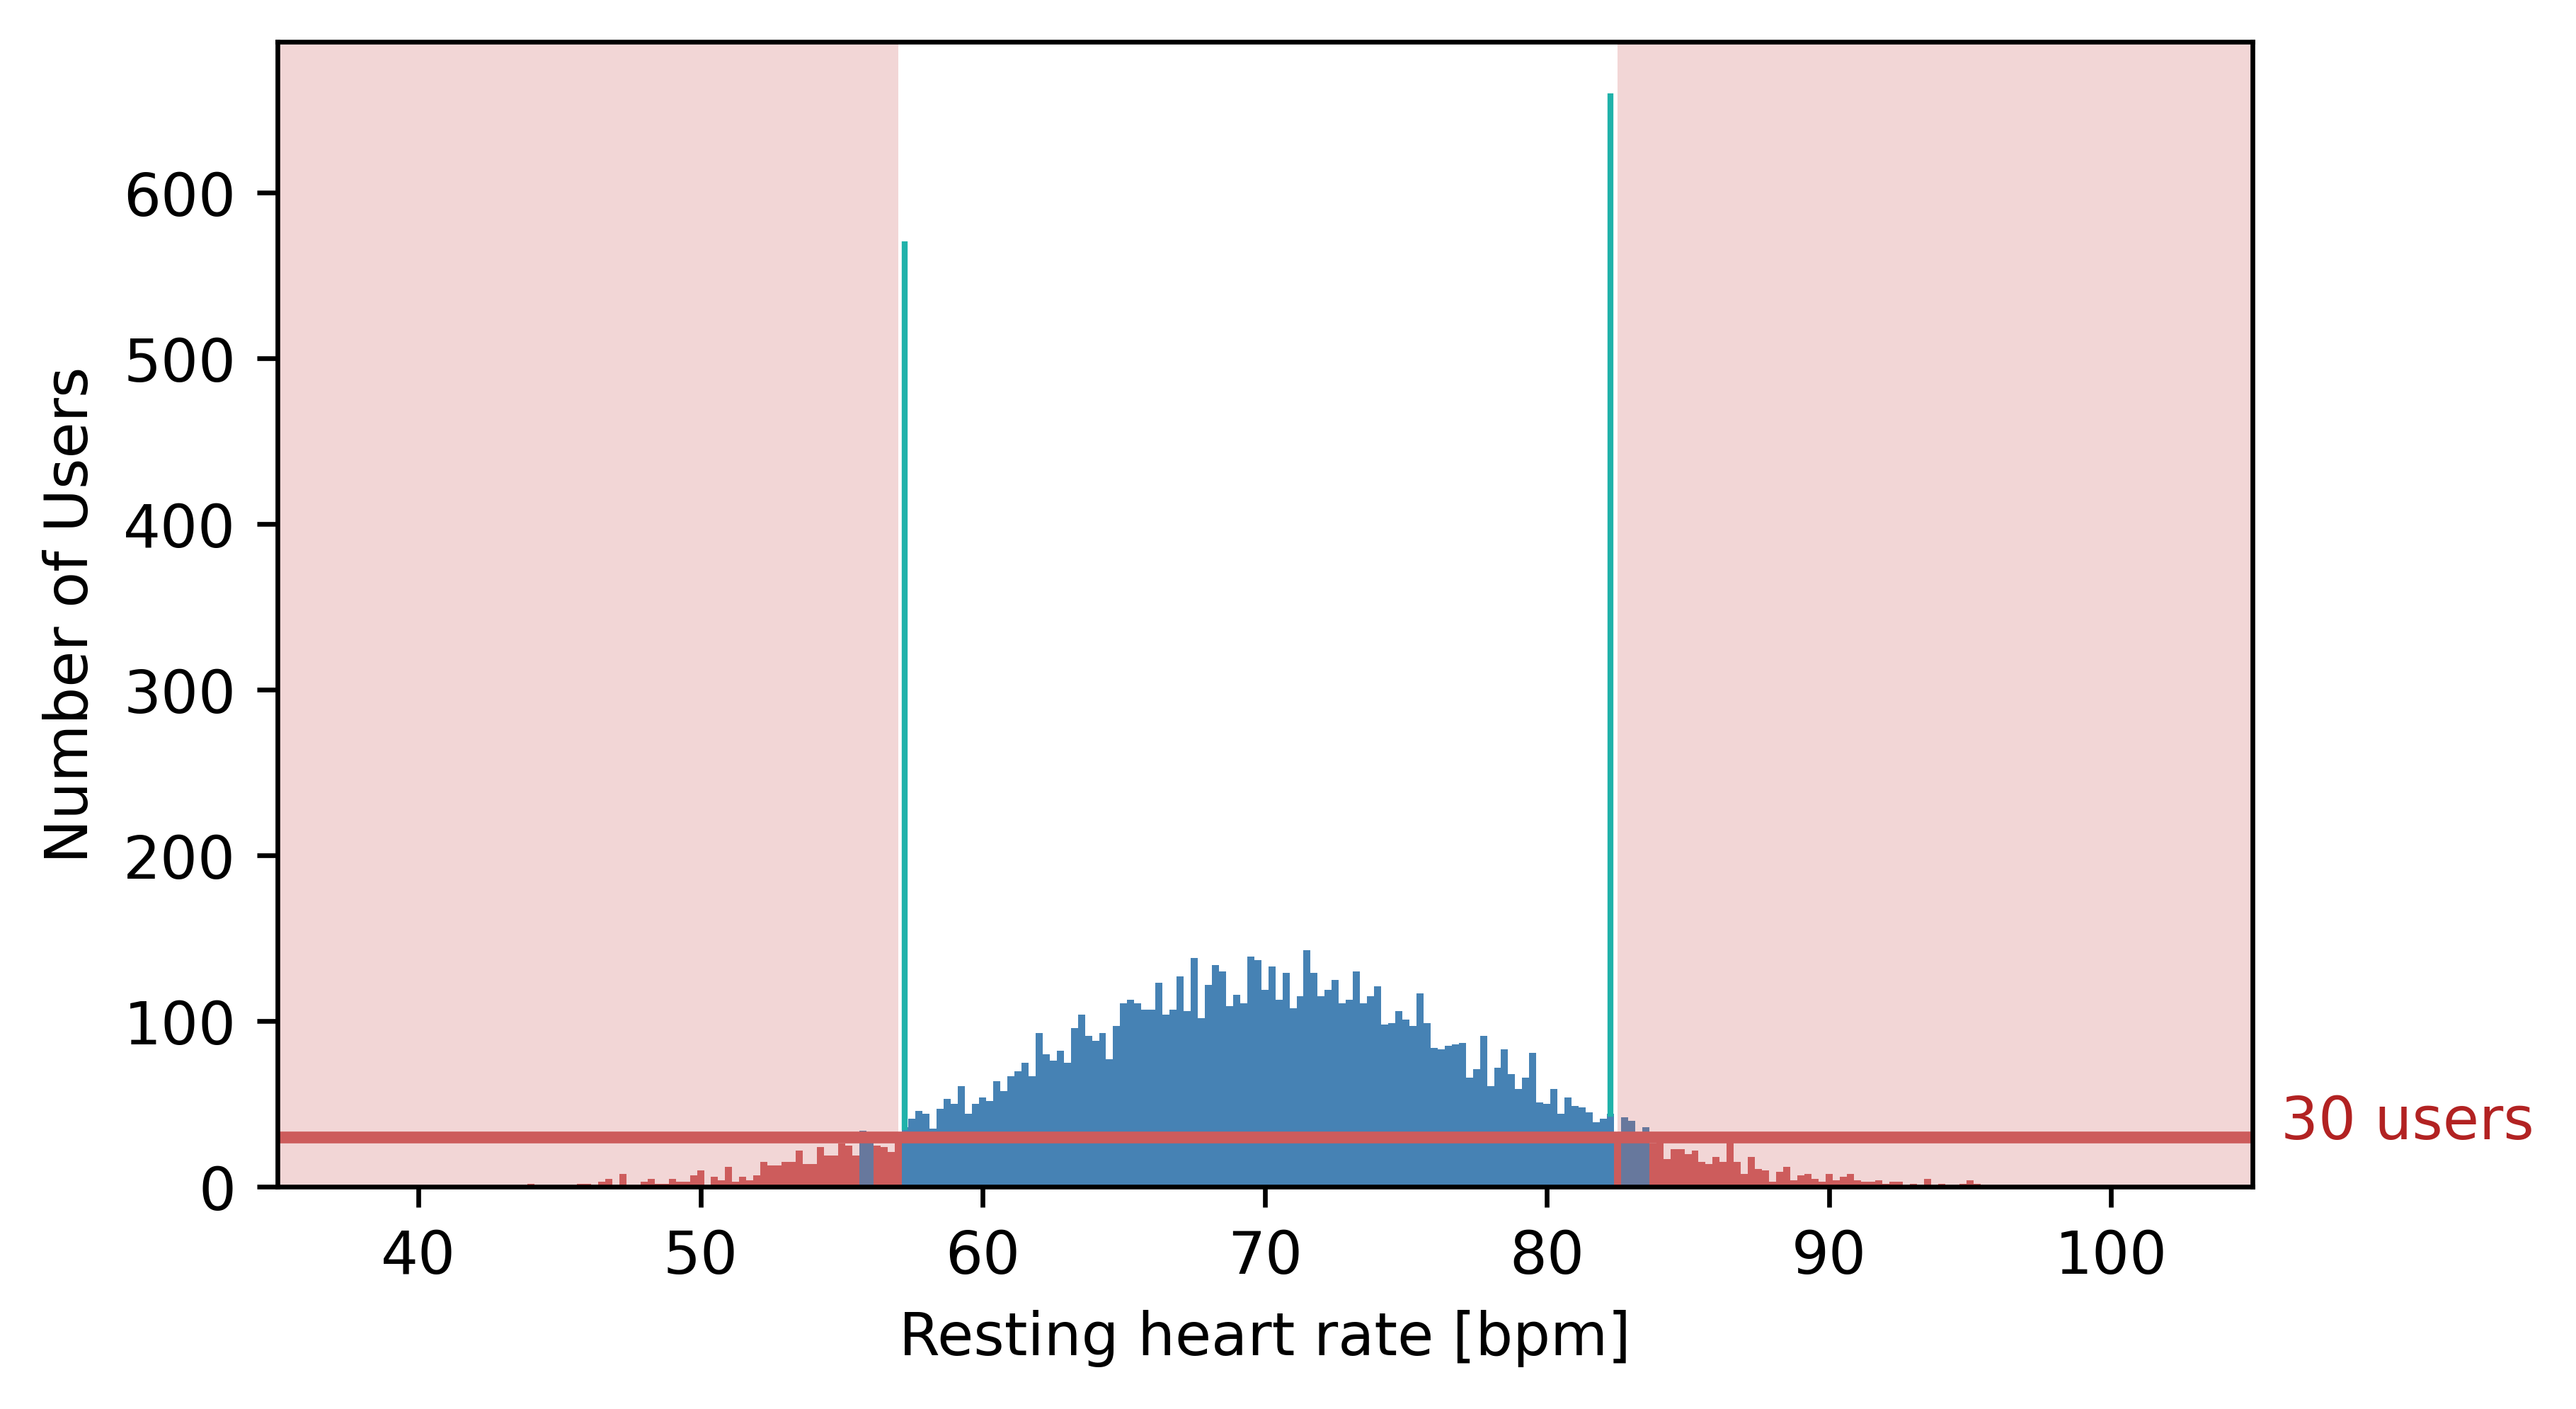

In [25]:
# Plot results with rounding factor 0.25
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=df_rounded_025["value"], height=df_rounded_025["count"], color=df_rounded_025["color"], width=0.25)
ax.set_xlim(left=35, right=105)
ax.set_xlabel("Resting heart rate [bpm]")
ax.set_ylabel("Number of Users")

# Plot users that are added on top of cap limits
ax.plot([left_cap_xlocation_025, left_cap_xlocation_025], [left_cap_ylocation_025, left_cap_ylocation_025+left_cap_size_025], linewidth=1, color="lightseagreen")
ax.plot([right_cap_xlocation_025, right_cap_xlocation_025], [right_cap_ylocation_025, right_cap_ylocation_025+right_cap_size_025], linewidth=1, color="lightseagreen")

# Plot min bucket size threshold
ax.text(x=106, y=29, s=f"{min_bucket_size} users", color="firebrick")
plt.plot([35, 105], [min_bucket_size, min_bucket_size], linewidth=2, color="indianred")

# Plot red capping areas
ax.axvspan(0, last_left_red_025, facecolor='indianred', alpha=0.25)
ax.axvspan(first_right_red_025, 105, facecolor='indianred', alpha=0.25)

fig.savefig("histogram_025", bbox_inches="tight")
plt.show()

### Process data frame with rounding factor: 0.25

In [28]:
rounding_factor = 1
df_rounded_1 = df_raw.copy()
df_rounded_1["value"] = df_rounded_1.apply(custom_rounding, args=(rounding_factor,), axis=1)
df_rounded_1["count"] = df_rounded_1.groupby("value")["value"].transform("count")
df_rounded_1["color"] = df_rounded_1.apply(check_bucket_size, axis=1)
df_rounded_1 = df_rounded_1.sort_values(by="value")

df_rounded_1

,value,count,color
0,74.0,436,steelblue
1,69.0,474,steelblue
2,75.0,416,steelblue
3,82.0,161,steelblue
4,68.0,493,steelblue
...,...,...,...
9995,80.0,231,steelblue
9996,54.0,69,steelblue
9997,64.0,359,steelblue
9998,74.0,436,steelblue


In [31]:
# Calculate cappings and users that need to be added to cap limits
red_buckets_1 = df_rounded_1[df_rounded_1["count"]<min_bucket_size]
left_red_buckets_1 = red_buckets_1[red_buckets_1["value"]<((red_buckets_1["value"].max()+red_buckets_1["value"].min())/2)]
right_red_buckets_1 = red_buckets_1[red_buckets_1["value"]>=((red_buckets_1["value"].max()+red_buckets_1["value"].min())/2)]
last_left_red_1 = left_red_buckets_1["value"].max()
first_right_red_1 = right_red_buckets_1["value"].min()
left_cap_xlocation_1 = last_left_red_1 + rounding_factor
right_cap_xlocation_1 = first_right_red_1 - rounding_factor
left_cap_ylocation_1 = df_rounded_1.groupby(["value"]).mean(numeric_only=True)["count"][left_cap_xlocation_1]
right_cap_ylocation_1 = df_rounded_1.groupby(["value"]).mean(numeric_only=True)["count"][right_cap_xlocation_1]
left_cap_size_1 = df_rounded_1[df_rounded_1["value"]<=last_left_red_1].groupby(["value"]).mean(numeric_only=True)["count"].sum()
right_cap_size_1 = df_rounded_1[df_rounded_1["value"]>=first_right_red_1].groupby(["value"]).mean(numeric_only=True)["count"].sum()

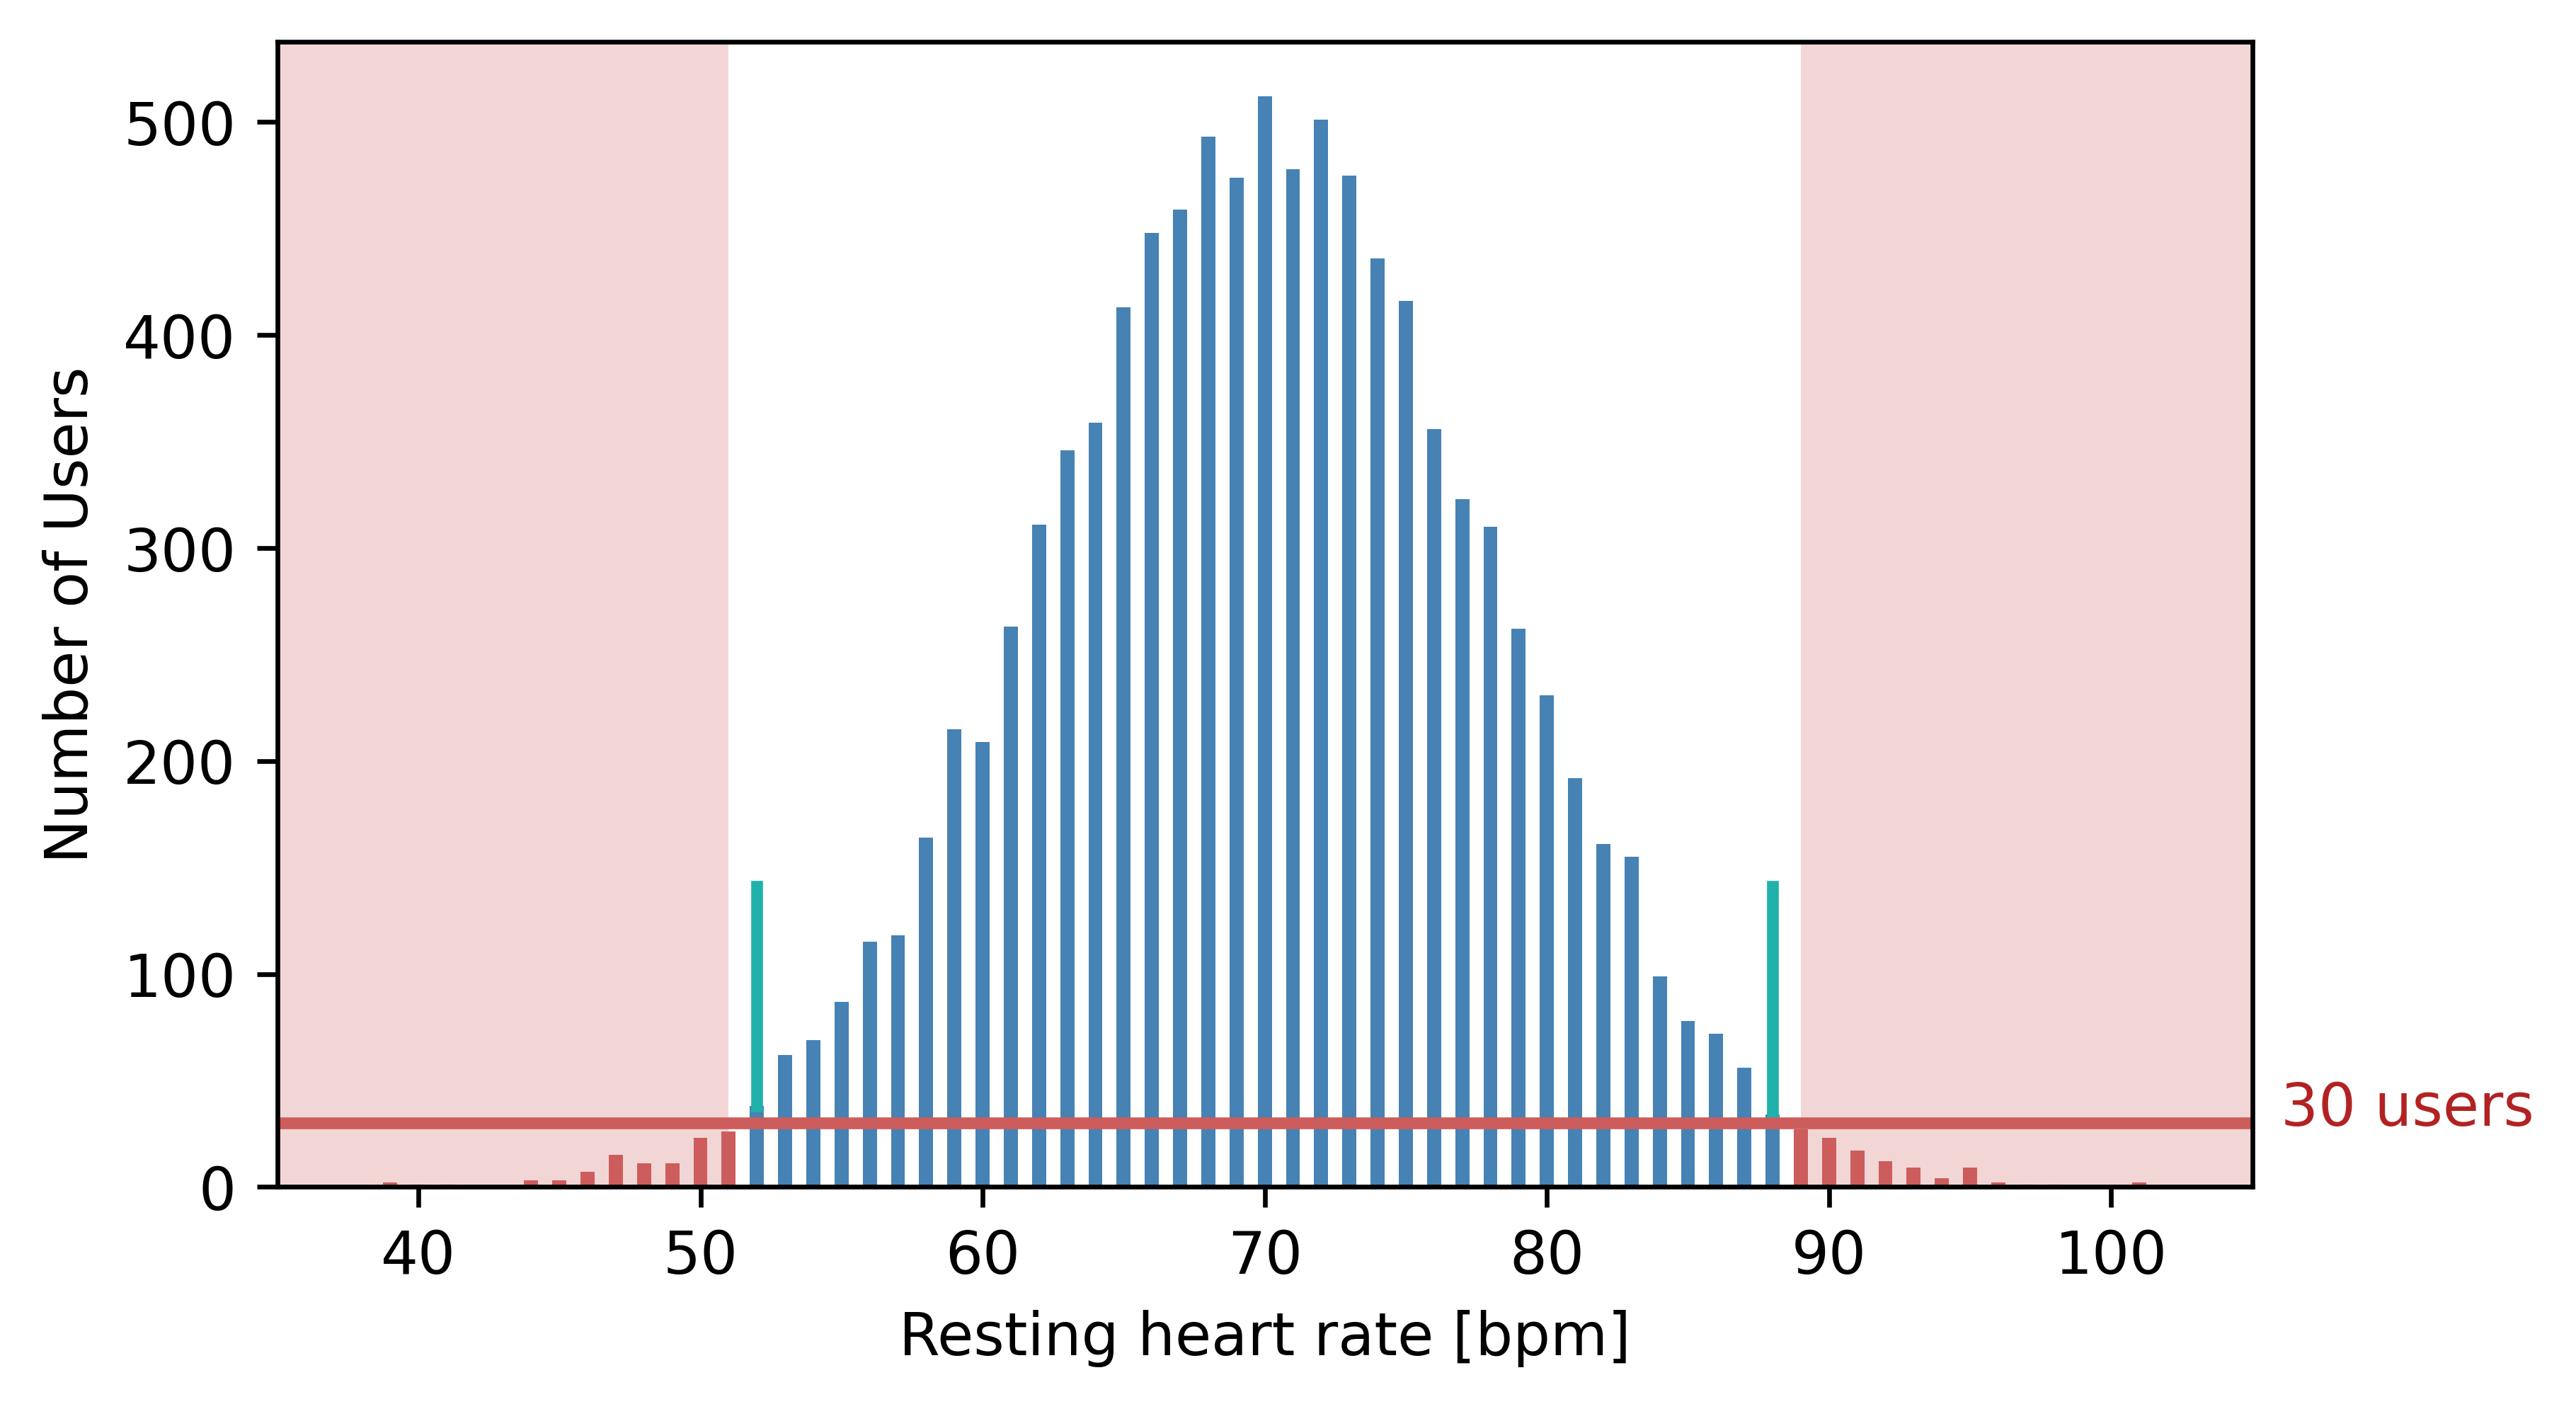

In [33]:
# Plot results with rounding factor 1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=df_rounded_1["value"], height=df_rounded_1["count"], color=df_rounded_1["color"], width=0.5)
ax.set_xlim(left=35, right=105)
ax.set_xlabel("Resting heart rate [bpm]")
ax.set_ylabel("Number of Users")

# Plot users that are added on top of cap limits
ax.plot([left_cap_xlocation_1, left_cap_xlocation_1], [left_cap_ylocation_1, left_cap_ylocation_1+left_cap_size_1], linewidth=2, color="lightseagreen")
ax.plot([right_cap_xlocation_1, right_cap_xlocation_1], [right_cap_ylocation_1, right_cap_ylocation_1+right_cap_size_1], linewidth=2, color="lightseagreen")

# Plot min bucket size threshold
ax.text(x=106, y=29, s=f"{min_bucket_size} users", color="firebrick")
plt.plot([35, 105], [min_bucket_size, min_bucket_size], linewidth=2, color="indianred")

# Plot red capping areas
ax.axvspan(0, last_left_red_1, facecolor='indianred', alpha=0.25)
ax.axvspan(first_right_red_1, 105, facecolor='indianred', alpha=0.25)

fig.savefig("histogram_1", bbox_inches="tight")
plt.show()

### Process data frame with rounding factor: 2

In [34]:
rounding_factor = 2
df_rounded_2 = df_raw.copy()
df_rounded_2["value"] = df_rounded_2.apply(custom_rounding, args=(rounding_factor,), axis=1)
df_rounded_2["count"] = df_rounded_2.groupby("value")["value"].transform("count")
df_rounded_2["color"] = df_rounded_2.apply(check_bucket_size, axis=1)
df_rounded_2 = df_rounded_2.sort_values(by="value")

df_rounded_2

,value,count,color
9770,38.0,1,indianred
7611,40.0,2,indianred
8200,40.0,2,indianred
7677,42.0,1,indianred
8180,44.0,6,indianred
...,...,...,...
1615,96.0,5,indianred
8248,98.0,2,indianred
6891,98.0,2,indianred
209,100.0,1,indianred


In [14]:
# Calculate cappings and users that need to be added to cap limits
red_buckets_2 = df_rounded_2[df_rounded_2["count"]<min_bucket_size]
left_red_buckets_2 = red_buckets_2[red_buckets_2["value"]<((red_buckets_2["value"].max()+red_buckets_2["value"].min())/2)]
right_red_buckets_2 = red_buckets_2[red_buckets_2["value"]>=((red_buckets_2["value"].max()+red_buckets_2["value"].min())/2)]
last_left_red_2 = left_red_buckets_2["value"].max()
first_right_red_2 = right_red_buckets_2["value"].min()
left_cap_xlocation_2 = last_left_red_2 + rounding_factor
right_cap_xlocation_2 = first_right_red_2 - rounding_factor
left_cap_ylocation_2 = df_rounded_2.groupby(["value"]).mean(numeric_only=True)["count"][left_cap_xlocation_2]
right_cap_ylocation_2 = df_rounded_2.groupby(["value"]).mean(numeric_only=True)["count"][right_cap_xlocation_2]
left_cap_size_2 = df_rounded_2[df_rounded_2["value"]<=last_left_red_2].groupby(["value"]).mean(numeric_only=True)["count"].sum()
right_cap_size_2 = df_rounded_2[df_rounded_2["value"]>=first_right_red_2].groupby(["value"]).mean(numeric_only=True)["count"].sum()

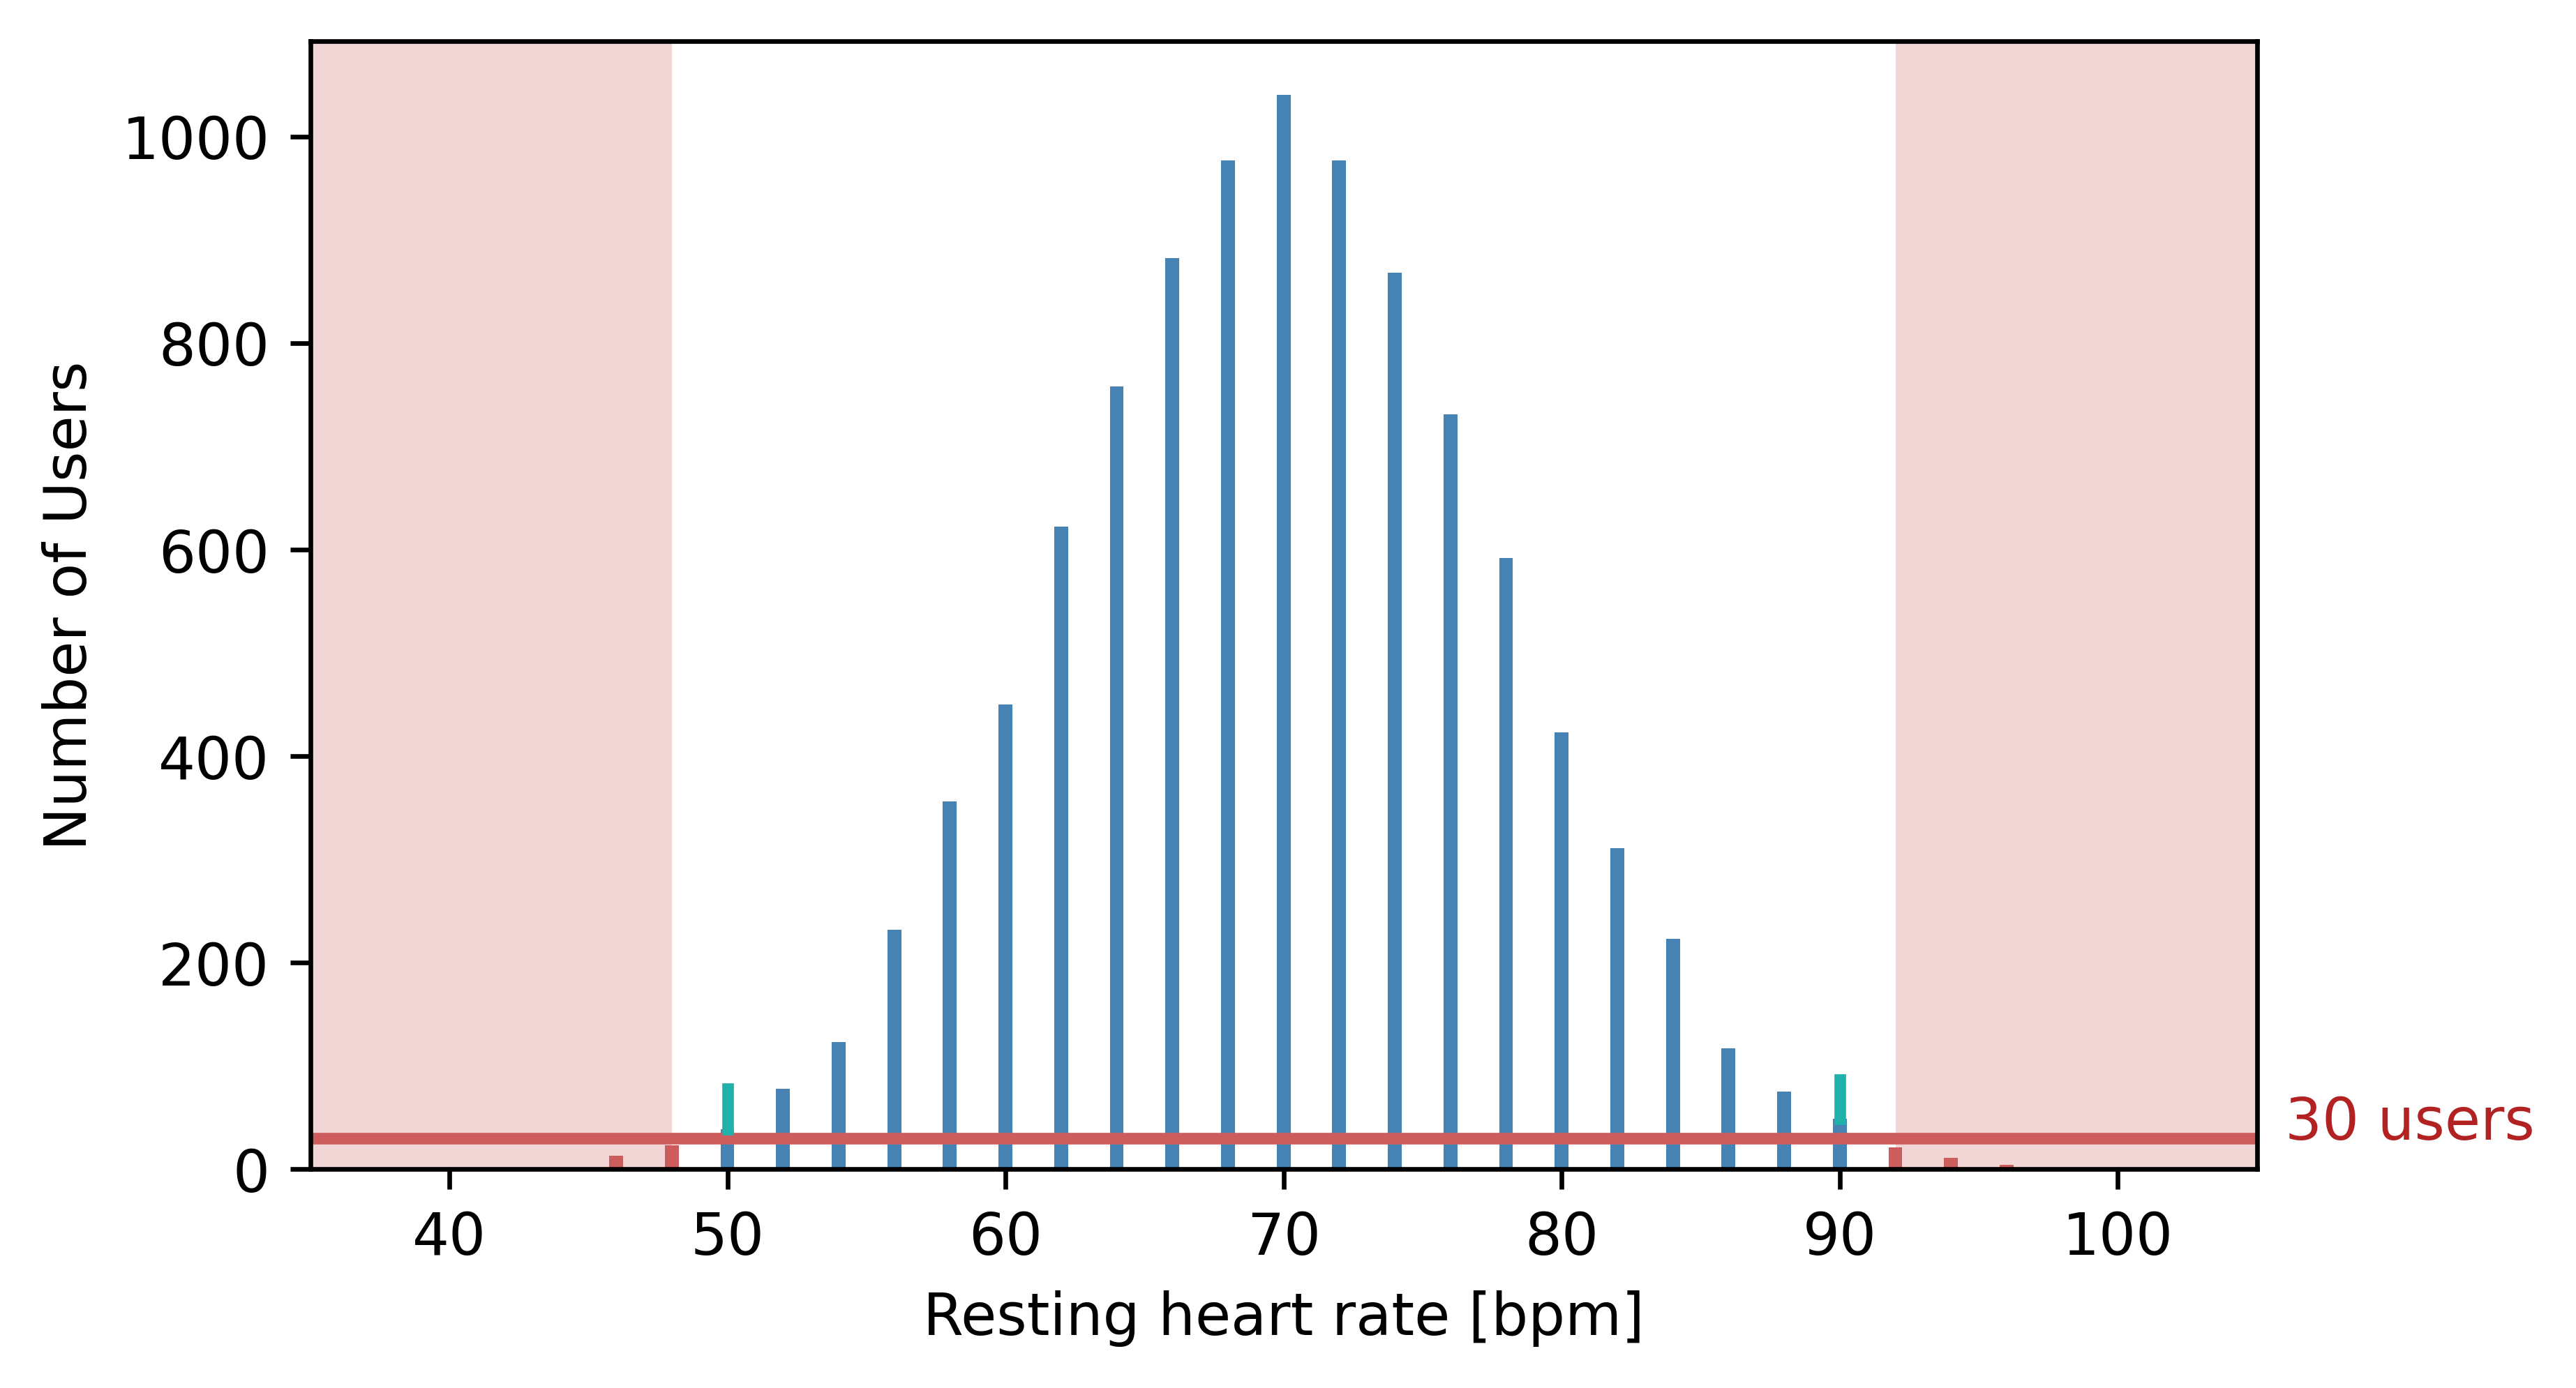

In [15]:
# Plot results with rounding factor 2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=df_rounded_2["value"], height=df_rounded_2["count"], color=df_rounded_2["color"], width=0.5)
ax.set_xlim(left=35, right=105)
ax.set_xlabel("Resting heart rate [bpm]")
ax.set_ylabel("Number of Users")

# Plot users that are added on top of cap limits
ax.plot([left_cap_xlocation_2, left_cap_xlocation_2], [left_cap_ylocation_2, left_cap_ylocation_2+left_cap_size_2], linewidth=2, color="lightseagreen")
ax.plot([right_cap_xlocation_2, right_cap_xlocation_2], [right_cap_ylocation_2, right_cap_ylocation_2+right_cap_size_2], linewidth=2, color="lightseagreen")

# Plot min bucket size threshold
ax.text(x=106, y=29, s=f"{min_bucket_size} users", color="firebrick")
plt.plot([35, 105], [min_bucket_size, min_bucket_size], linewidth=2, color="indianred")

# Plot red capping areas
ax.axvspan(0, last_left_red_2, facecolor='indianred', alpha=0.25)
ax.axvspan(first_right_red_2, 105, facecolor='indianred', alpha=0.25)

fig.savefig("histogram_2", bbox_inches="tight")
plt.show()

### Simulate values to illustrate aggregation of weekly measurements

In [35]:
# Generate raw values for a single user's resting heart rate measurements
time = np.sort(np.random.uniform(low=0.5, high=7.5, size=42))
resting_heart_rate = np.round(np.random.normal(loc=65, scale=8, size=42), decimals=0).astype(int)
df_user = pd.DataFrame({"time":time, "resting_heart_rate":resting_heart_rate})
df_user.head()

,time,resting_heart_rate
0,0.861635,63
1,1.002653,62
2,1.159932,70
3,1.221134,81
4,1.458756,66


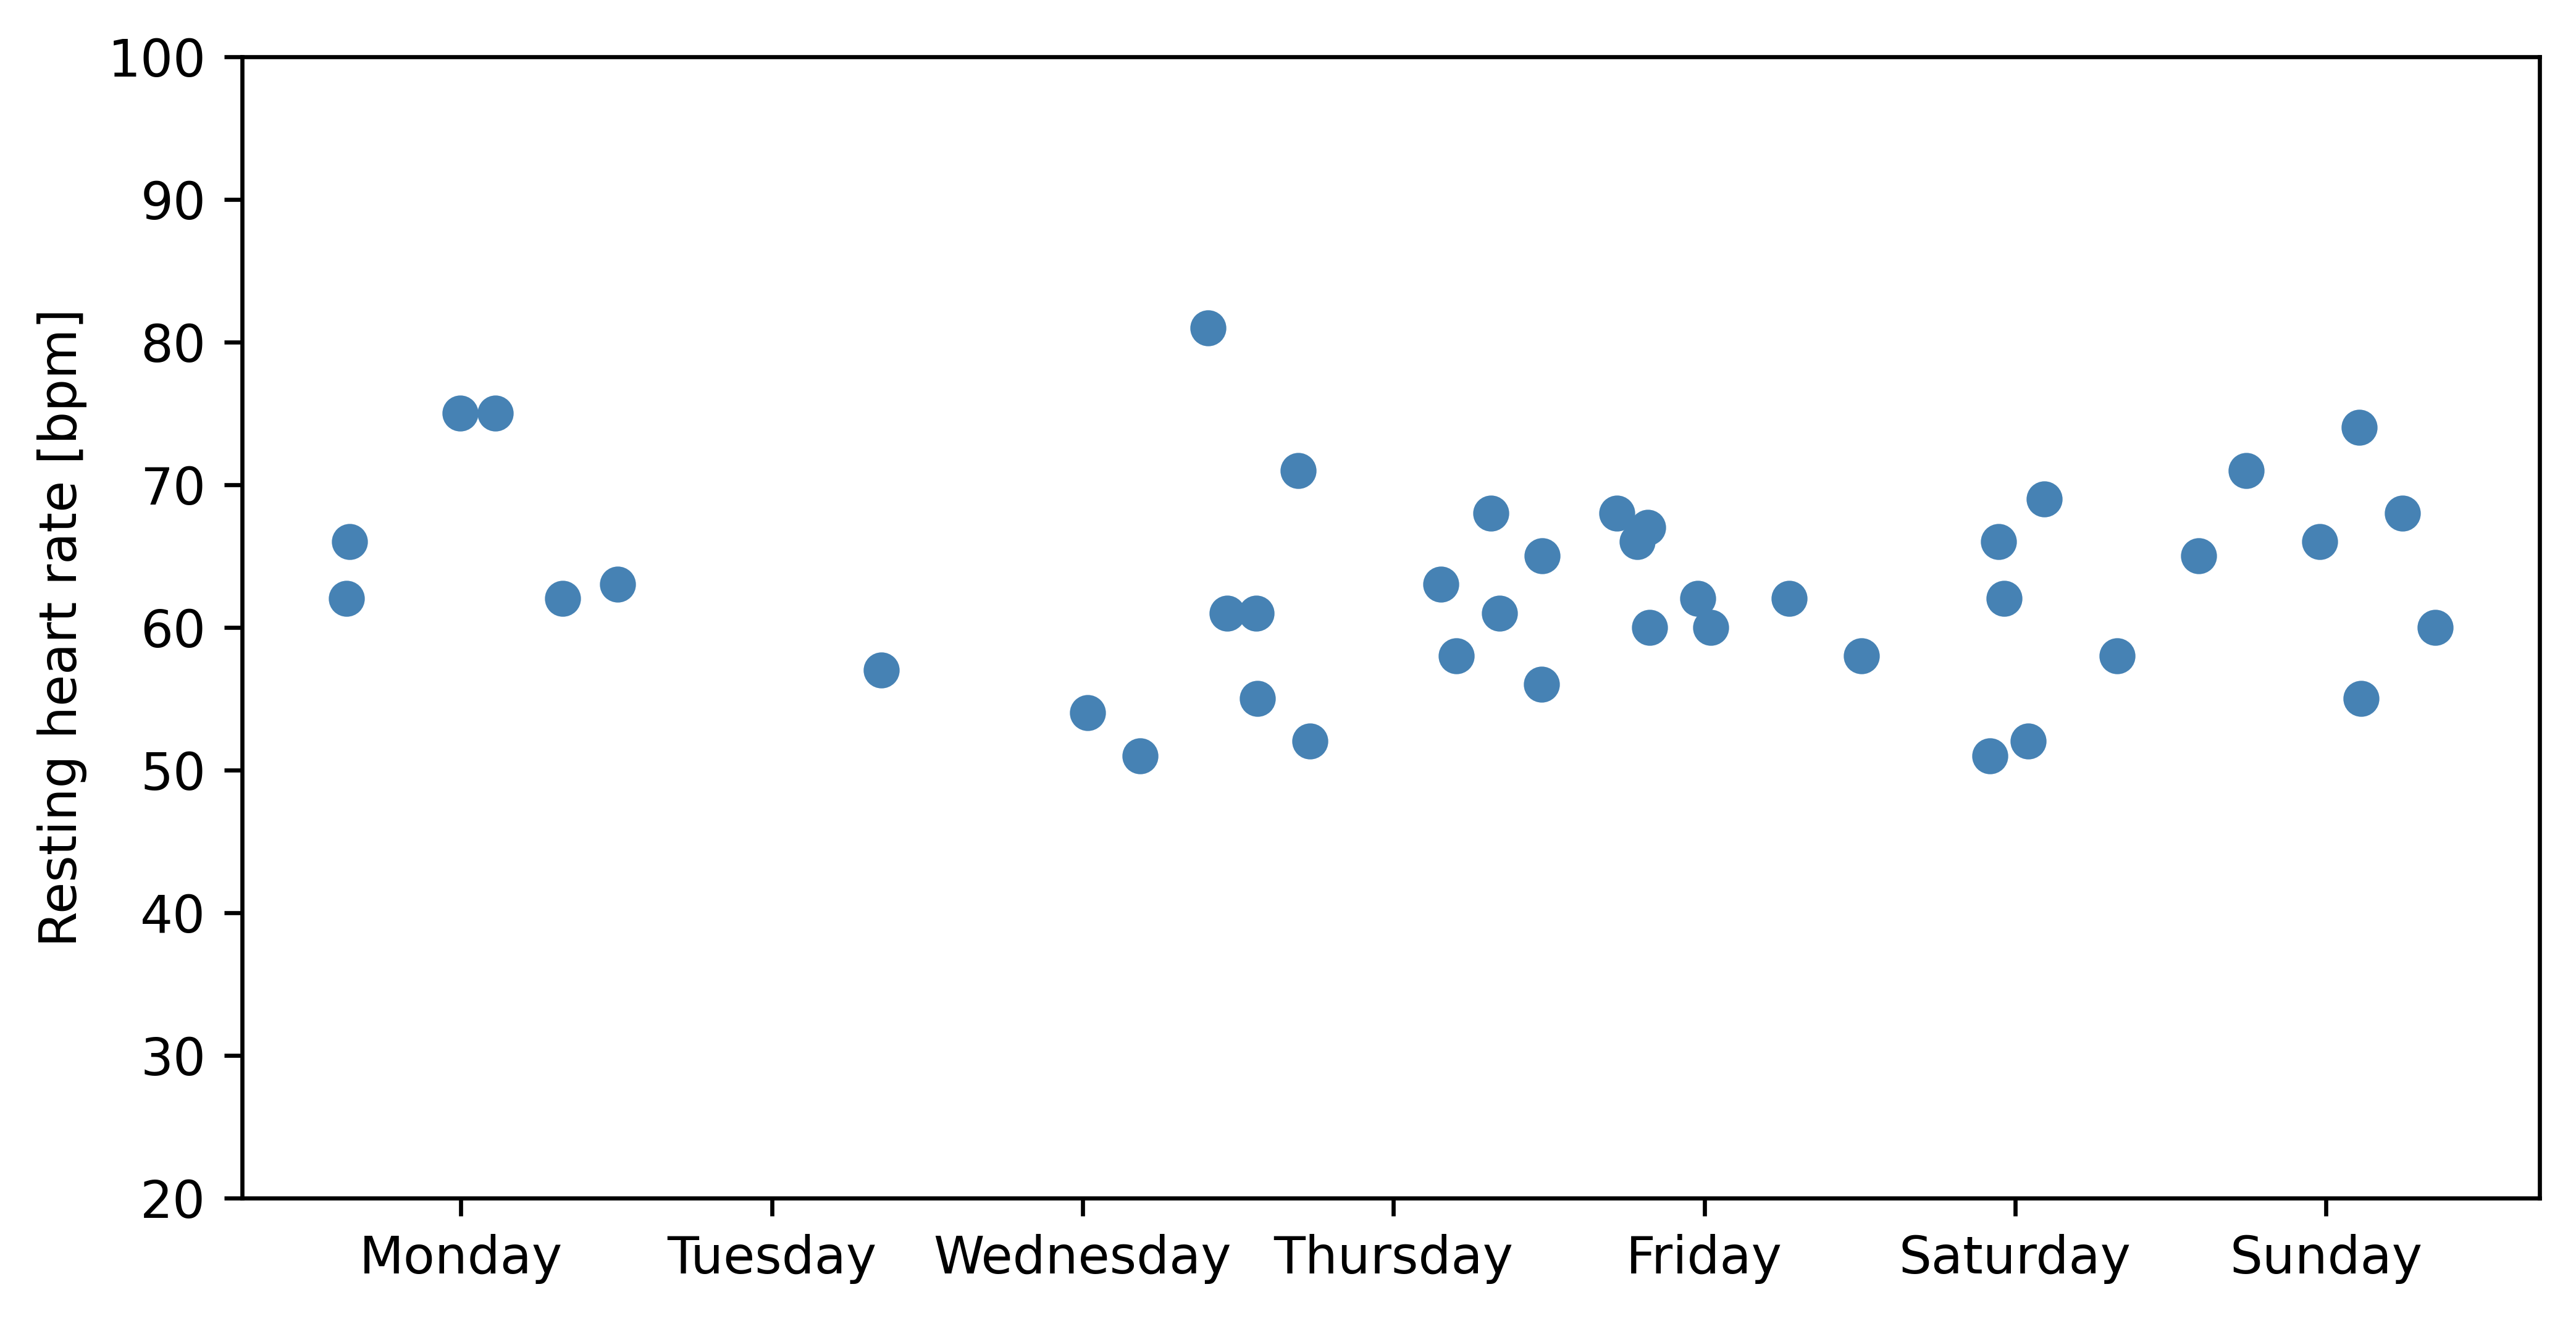

In [19]:
# Plot the measurements
fig = plt.figure()
fig.set_size_inches(8, 4, forward=True)
ax = fig.add_subplot(111)
ax.scatter(x=df_user["time"], y=df_user["resting_heart_rate"], color="steelblue")
ax.set_ylim(bottom=20, top=100)
ax.set_ylabel("Resting heart rate [bpm]")
ax.set_xticks(ticks=range(1,8,1), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

fig.savefig("measurements", bbox_inches="tight")
plt.show()

In [20]:
df_user.describe()

,time,resting_heart_rate
count,42.000000,42.000000
mean,4.464091,62.785714
std,1.903040,6.937124
min,0.631529,51.000000
25%,3.488994,58.000000
50%,4.599191,62.000000
75%,5.959552,66.750000
max,7.350328,81.000000


In [21]:
df_user["resting_heart_rate"].value_counts()

62    5
66    4
60    3
68    3
58    3
61    3
55    2
65    2
52    2
71    2
51    2
63    2
75    2
81    1
54    1
57    1
56    1
67    1
69    1
74    1
Name: resting_heart_rate, dtype: int64